Implement a denoising autoencoder that removes noise from images.
Train using dataset with artificially added noise.
Compare noisy and reconstructed images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


In [2]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train, x_test = x_train / 255.0, x_test / 255.0


x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)


print(x_train.shape, x_val.shape, x_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


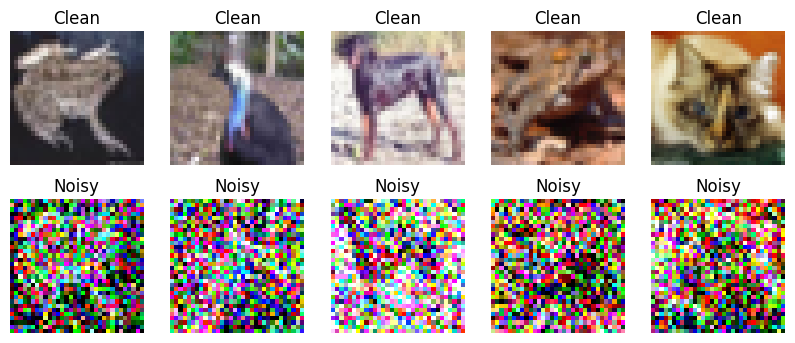

In [3]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images


x_train_noisy = add_noise(x_train)
x_val_noisy = add_noise(x_val)
x_test_noisy = add_noise(x_test)


def plot_images(original, noisy, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Clean")
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis("off")
    plt.show()

plot_images(x_train, x_train_noisy)


In [4]:
def build_denoising_autoencoder(input_shape):
    model = models.Sequential()


    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))


    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'))  # Output layer with 3 channels (RGB)

    return model


input_shape = x_train.shape[1:]
autoencoder = build_denoising_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:

history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=10,
                          batch_size=64,
                          validation_data=(x_val_noisy, x_val))


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 212ms/step - loss: 0.0208 - val_loss: 0.0125
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 220ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 234ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 215ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 219ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 213ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 219ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 216ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 223ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 222ms/step - loss: 0.0103 - val_loss: 0.0104


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step


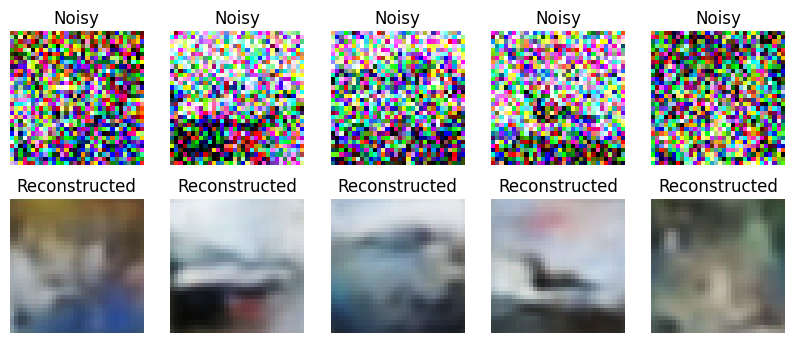

In [6]:

x_test_reconstructed = autoencoder.predict(x_test_noisy)


def compare_images(noisy_images, reconstructed_images, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(noisy_images[i])
        plt.title("Noisy")
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

compare_images(x_test_noisy, x_test_reconstructed)


In [7]:
import tensorflow as tf

def compute_reconstruction_loss(original_images, reconstructed_images):

    loss = tf.reduce_mean(tf.square(original_images - reconstructed_images))
    return loss


reconstruction_loss = compute_reconstruction_loss(x_test, x_test_reconstructed)
print(f'Reconstruction Loss: {reconstruction_loss.numpy()}')


Reconstruction Loss: 0.010324604216693834


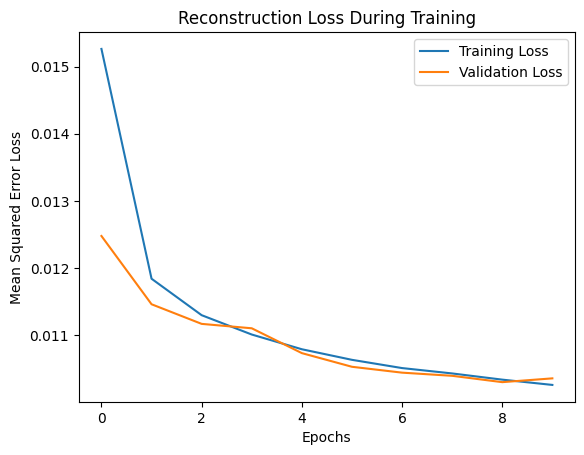

In [8]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.title('Reconstruction Loss During Training')
plt.show()


In [9]:

test_reconstruction_loss = compute_reconstruction_loss(x_test, x_test_reconstructed)
print(f'Test Set Reconstruction Loss: {test_reconstruction_loss.numpy()}')


Test Set Reconstruction Loss: 0.010324604216693834
